# Response time minimization - West police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### West police district
West police district covers 38 municipalities in Vestland county, with a total of 598,000 inhabitants. The police district does not completely follow the county borders - the municipalities of Fitjar, Bømlo, Stord, Etne and Sveio belong to the South-West police district. The police district has approximately 1,300 employees. The police chief and the joint operations center are located in Bergen.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-27T12:40:00.128382+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.1
pandana   : 0.7
geopandas : 0.14.3
matplotlib: 3.8.3
osmnx     : 1.9.1
numpy     : 1.26.4



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [3]:
### Load road network from file
West_filepath = "../data/West/WestDriveImputed.graphml" # with travel time attribute
West_graph = ox.load_graphml(West_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
West_graph = ox.projection.project_graph(West_graph)
print(f"Type of West_graph: {type(West_graph)}")
print(f"CRS of West_graph:  {West_graph.graph['crs']}")

# # plot graph
# fig, ax = ox.plot_graph(West_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of West_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of West_graph:  EPSG:32632


Convert MultiDiGraph to node and edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(West_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid ref         name  highway maxspeed  oneway  \
u        v          key                                                         
33720590 7310207941 0     80499834  49  Opheimsgata  primary       30   False   
         7310208284 0    782796870  49  Opheimsgata  primary       30    True   

                        reversed  length  \
u        v          key                    
33720590 7310207941 0      False  64.781   
         7310208284 0      False  13.224   

                                                                  geometry  \
u        v          key                                                      
33720590 7310207941 0    LINESTRING (363412.838 6661377.849, 363363.499...   
         7310208284 0    LINESTRING (363412.838 6661377.849, 363417.249...   

                         speed_kph  travel_time junction width est_width  \
u        v          key                                                    
33720590 7310207941 0       30.000        7.800      NaN   NaN       NaN   
         7310208284 0       30.000        1.600      NaN   NaN       NaN   

                        lanes tunnel bridge access service  
u        v          key                                     
33720590 7310207941 0     NaN    NaN    NaN    NaN     NaN  
         7310208284 0     NaN    NaN    NaN    NaN     NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [6]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid ref         name  highway maxspeed  oneway  \
u        v          key                                                         
33720590 7310207941 0     80499834  49  Opheimsgata  primary       30   False   
         7310208284 0    782796870  49  Opheimsgata  primary       30    True   

                        reversed  length  \
u        v          key                    
33720590 7310207941 0      False  64.781   
         7310208284 0      False  13.224   

                                                                  geometry  \
u        v          key                                                      
33720590 7310207941 0    LINESTRING (363412.838 6661377.849, 363363.499...   
         7310208284 0    LINESTRING (363412.838 6661377.849, 363417.249...   

                         speed_kph  travel_time junction width est_width  \
u        v          key                                                    
33720590 7310207941 0       35.900        6.496      NaN   NaN       NaN   
         7310208284 0       35.900        1.326      NaN   NaN       NaN   

                        lanes tunnel bridge access service  
u        v          key                                     
33720590 7310207941 0     NaN    NaN    NaN    NaN     NaN  
         7310208284 0     NaN    NaN    NaN    NaN     NaN

In [7]:
# recombining nodes and increased edges to MultiDiGraph format
West_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [8]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
West_polygon_path = "../data/West/WestCombinedPolygon.geojson"
West_polygon_gdf = gpd.read_file(West_polygon_path)
West_polygon_gdf = West_polygon_gdf.to_crs(West_graph.graph['crs']) # convert to same CRS as the road network

In [9]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/West/WestPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(West_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  19565006692500           5   
1  19567506692500           2   

                                            geometry  
0  POLYGON ((289839.386 6658211.700, 289816.728 6...  
1  POLYGON ((290087.586 6658234.358, 290064.929 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [11]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=3500, max_range=3700) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 3611. Target range [3500, 3700], using population multiplier: 0.008347656250000002


id  population  \
3904  19680006733500        1333   
3944  19680006735250        1278   
3945  19682506735250        1273   

                                               geometry  num_points  
3904  POLYGON ((297534.338 6699962.418, 297511.596 6...          11  
3944  POLYGON ((297375.135 6701699.963, 297352.390 6...          11  
3945  POLYGON ((297623.356 6701722.708, 297600.611 6...          11

In [12]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (288306.852 6657665.547)
1  POINT (288099.804 6658424.723)
2  POINT (289541.033 6668053.124)

In [13]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=5.0e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 8.152e-46 | Median: 2.333e-12 | Mean: 2.182e-11 | Max: 1.186e-09


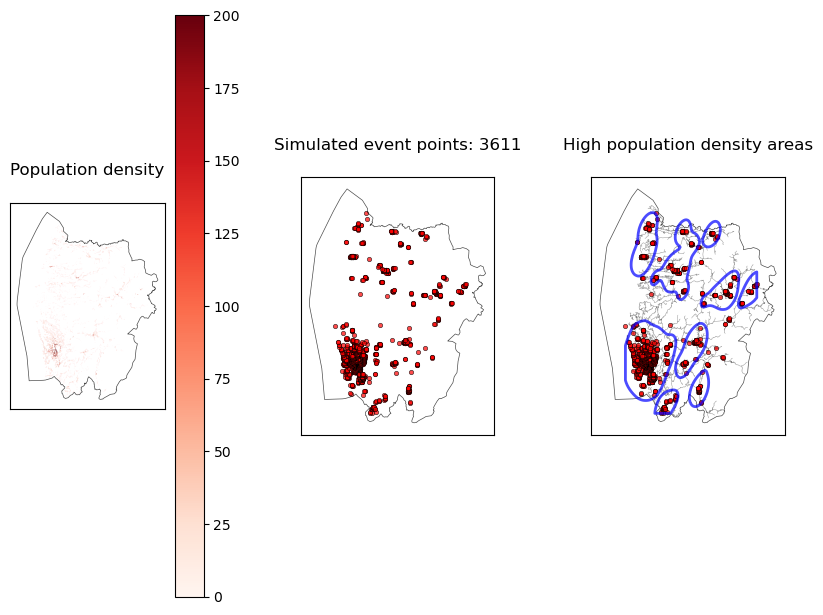

In [14]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(West_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [15]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/West/WestNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count   lon    lat highway  ref  \
osmid                                                                       
33720590   6661377.849 363412.838             3 6.546 60.067     NaN  NaN   
7310207941 6661390.219 363349.023             4 6.545 60.067     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
33720590    POINT (363412.838 6661377.849)                 0.000   
7310207941  POINT (363349.023 6661390.219)                 0.000   

            betweenness_centrality  
osmid                               
33720590                  7357.000  
7310207941             1441838.000

### 2.2 Sample candidate points and filter out best candidate points

In [16]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 33779, nr of police car nodes: 100


y          x  street_count   lon    lat         highway  \
osmid                                                                          
4761665743 6869119.756 299802.624             1 5.188 61.902  turning_circle   
560517728  6711858.719 294514.278             1 5.259 60.490             NaN   

            ref                        geometry  closeness_centrality  \
osmid                                                                   
4761665743  NaN  POINT (299802.624 6869119.756)                 0.000   
560517728   NaN  POINT (294514.278 6711858.719)                 0.000   

            betweenness_centrality  
osmid                               
4761665743                   0.000  
560517728                    0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 95, after discarding the 5 (5%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


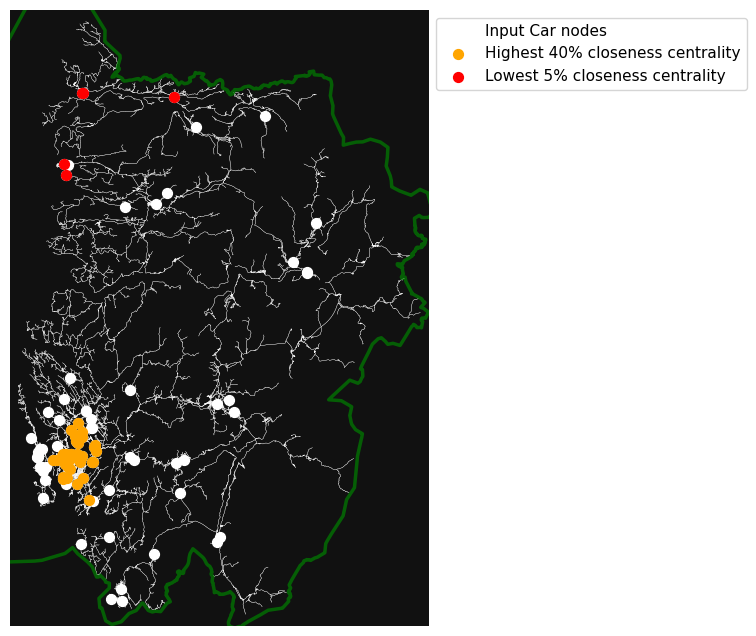

In [17]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=West_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.05, input_graph=West_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 95
Remaining nr of car nodes: 57, after discarding the 38 (40%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


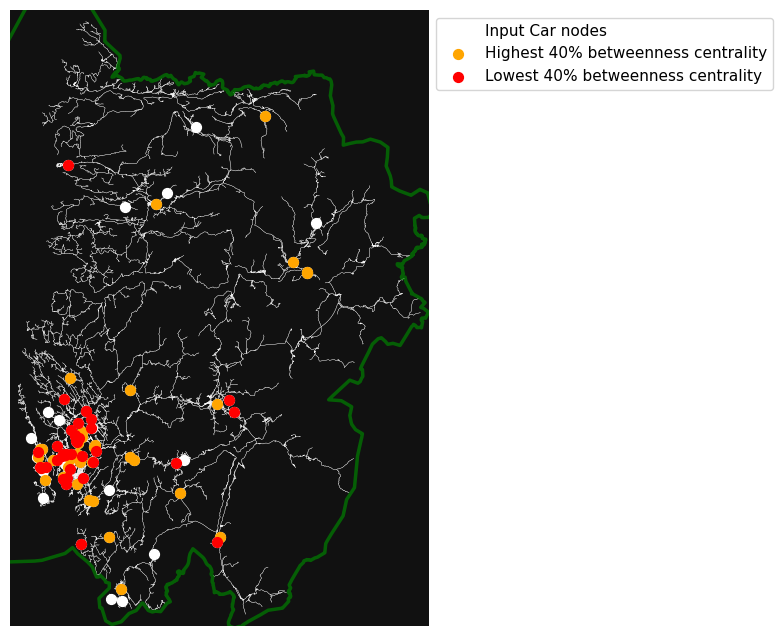

In [18]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=West_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.40, input_graph=West_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 57
Remaining nr of car nodes: 24, after removing the 33 nodes that are within 8000 m of each other



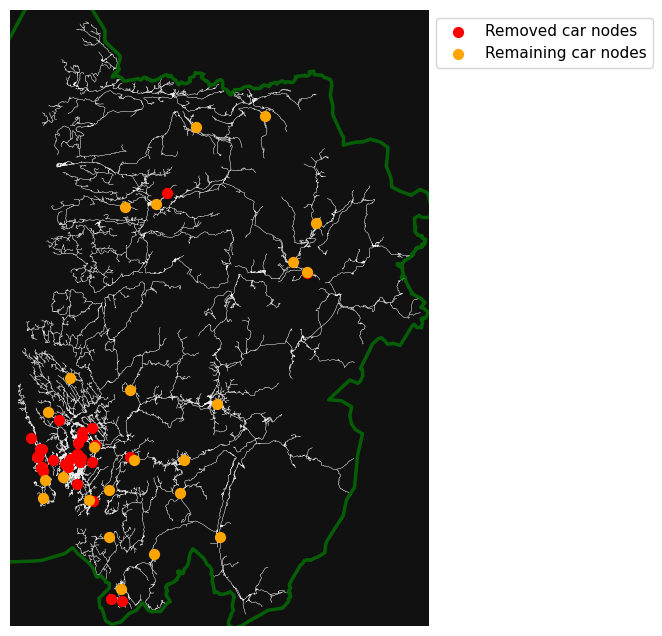

In [19]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=West_polygon_gdf, 
                             min_distance=8000, input_graph=West_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [20]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
West_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of West_network_pdna: {type(West_network_pdna)}")
print(f"Network nodes:")
West_network_pdna.nodes_df.head(2)

type of West_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
33720590   363412.838 6661377.849
7310207941 363349.023 6661390.219

In [21]:
print(f"Network edges: ")
West_network_pdna.edges_df.head(2)

Network edges: 


from          to  length  travel_time
0  33720590  7310207941  64.781        6.496
1  33720590  7310208284  13.224        1.326

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [22]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = West_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node          x           y
6  POINT (298030.375 6671716.161) 5284963570.000 297908.410 6671791.600
7  POINT (297847.353 6672390.975) 5284965351.000 298044.325 6671971.397

In [23]:
# Get list of nearest node ids for event locations
event_nodes_pdna = West_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = West_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([ 509287655,  965180471, 6985564544, 5905938091,   60830888],
      dtype=int64)

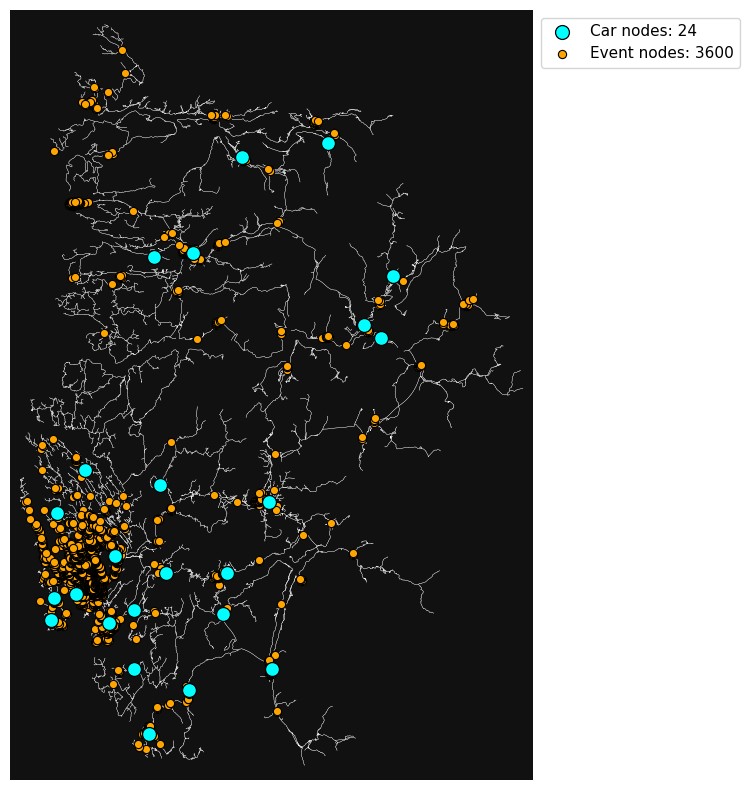

In [24]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(West_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# travel time between each possible pair of car-event combination
distances = West_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = West_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

24 origins x 3600 destinations = 86400 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [42742.614, 42558.959, 41703.684, 41371.086, 41781.63]
5 first origin-destination travel times [sec]: [1937.291, 1921.348, 1874.125, 1848.615, 1872.674]
CPU times: total: 2.28 s
Wall time: 273 ms


In [27]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count    mean     std   min    25%     50%     75%     max
0 86400.000 145.192 115.043 0.000 38.842 113.645 244.894 489.865

In [28]:
# Restructure the distances and travel times arrays into a DataFrame (CWest Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID          x           y
0 42742.614     1937.291  509287655   5284963570 297908.410 6671791.600
1 42558.959     1921.348  509287655   5284965351 298044.325 6671971.397

In [29]:
# Save cWest matrix to CSV
CostMatrix.to_csv("../data/West/WestCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [30]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID   eventNodeID
0     1937.291  509287655  5284963570_1
1     1921.348  509287655  5284965351_1

In [31]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 9
# margin = len(event_nodes_pdna) * 0.05 # 5% of all events
# CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
CAR_CAPACITY = 450
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 450 events per car
Filtering out 0% highest travel times - keeping only travel times <= 29392 sec, or 489.9 min
Original nr of pairs: 86400 | Filtered nr of pairs: 86400
Original max travel time: 29391.915 | Filtered max travel time: 29391.915


### 5.2 Setup LP problem

In [32]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 24
Number of events: 3600
Number of decision variables: 86424
Number of constraints: 90025
Number of non-zero coefficients: 86424
Number of non-zero coefficients in the objective function: 86398
CPU times: total: 2.67 s
Wall time: 3.82 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [33]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 7/9 locations in 11.54 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 9/9 in 1492.81 seconds: [ 509287655  965180471   60830888 1903634060 1319406280 6024684484
 9794424030 6354137939 2097138238]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 5201696.0460 seconds, or 86694.93 minutes, or 1444.92 hours
CPU times: total: 10 s
Wall time: 25min 12s


### 5.6 Extract results for inspection

In [34]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/West/WestCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([509287655, 965180471, 60830888, 1903634060, 1319406280, 6024684484, 9794424030, 6354137939, 2097138238])
Car 509287655 is assigned 450/450 events
Car 965180471 is assigned 450/450 events
Car 60830888 is assigned 396/450 events
Car 1903634060 is assigned 450/450 events
Car 1319406280 is assigned 450/450 events
Car 6024684484 is assigned 279/450 events
Car 9794424030 is assigned 225/450 events
Car 6354137939 is assigned 450/450 events
Car 2097138238 is assigned 450/450 events
Summing the events for each car gives 3600 events, which should equal the total number of unique events: 3600


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 24 | Optimal locations in solution: 9
- Events: 3600 | Max event capacity per police car: 450

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 5201696 sec | 86694.9 min | 1444.92 hours

Car id: 509287655 handles 450 events | Capacity: 100.00% | Total response time: 5279.52 min | Median: 12.36 min | Avg: 11.73 min
Car id: 965180471 handles 450 events | Capacity: 100.00% | Total response time: 8312.63 min | Median: 18.91 min | Avg: 18.47 min
Car id: 60830888 handles 396 events | Capacity: 88.00% | Total response time: 20898.96 min | Median: 41.55 min | Avg: 52.78 min
Car id: 1903634060 handles 450 events | Capacity: 100.00% | Total response time: 3788.80 min | Median: 9.21 min | Avg: 8.42 min
Car id: 1319406280 handles 450 events | Capacity: 100.00% | Total response time: 4343.11 min | Median: 10.00 min | Avg: 9.65 min
Car id: 6024684484 handles 279 events | C

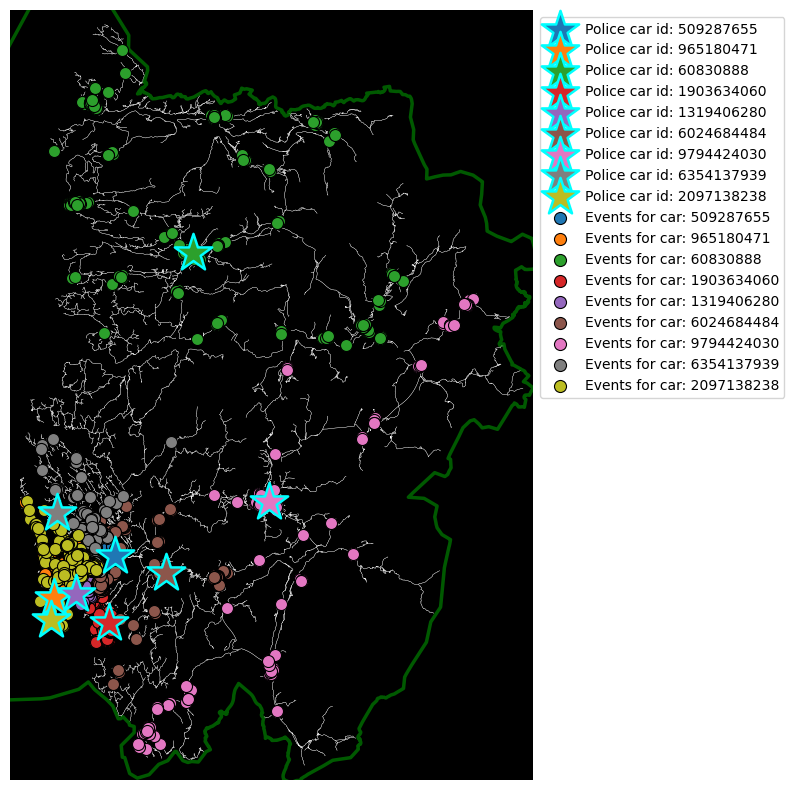

CPU times: total: 4.23 s
Wall time: 5.56 s


In [35]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(West_graph, West_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [40]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [41]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(West_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=350, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 3min 49s
Wall time: 4min 45s


Isochrone polygons for the travel times: [20, 60, 120] minutes


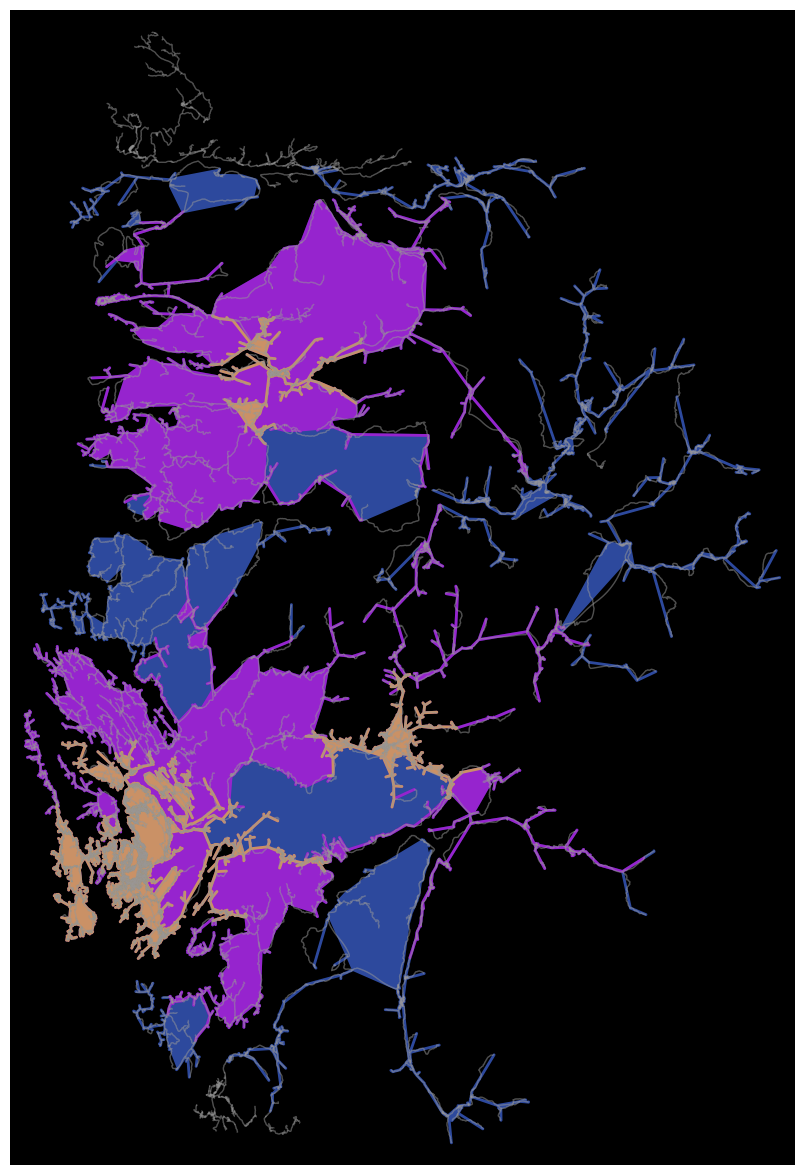

In [42]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(West_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [43]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(West_graph, TRIP_TIMES, merged_isochrones, West_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 875 ms
Wall time: 1.19 s
